In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from classifier import Classifier

In [8]:
csv_name = "2014-final.xlsx - Sheet1.csv"

In [9]:
classified = Classifier(csv_name)

In [10]:
def percentages(df, column):
    df = lis.groupby([column], as_index=False)['Totals'].sum()
    df['Percentages'] = round(((df['Totals'] / df['Totals'].sum()) * 100), 1)
    df = df.loc[(df[column] != "") & (df['Totals'] != 0)]
    return df

## 1. What fraction of the total cell number are mixotrophs and what fraction are phytoplankton (strict phototrophs)? 
### For this question, we could also aggregate the data by adding all the surface samples together on a given sampling day and comparing that to the bottom samples.  Or we could see if the fraction of mixoplankton changes as we go from West to East (stations A to K), because there is a big decrease in the amount of nutrients like nitrogen that are added to the Sound as you get farther East (away from NYC), so there might be more of a need for mixoplankton to get their nitrogen by eating as you go to the East.

In [13]:
# Clean Data
lis = classified.all_classified
lis
lis.loc[lis['Genus']=='Protoperidinium', 'Status'] = 'Heterotroph'
lis = lis.replace('No', 'Phototroph')
lis = lis.replace('Yes', 'Mixotroph')
counts = percentages(lis, 'Status')
counts

,Status,Totals,Percentages
0,Heterotroph,38060.0,0.044195
1,Mixotroph,30162790.714,35.024617
2,Phototroph,55917979.66,64.931188


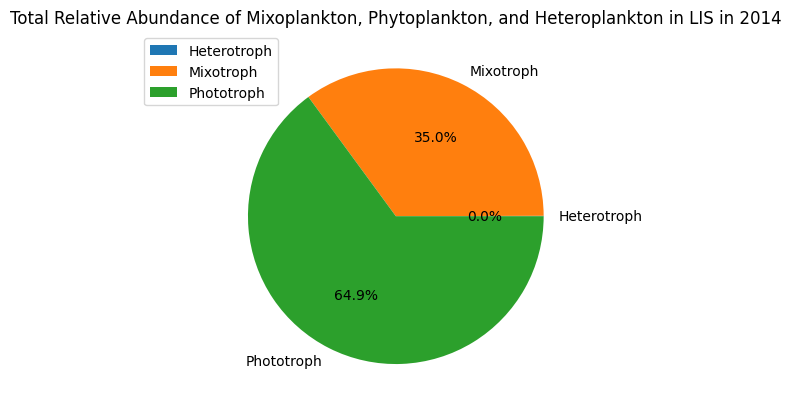

In [14]:
# Plot Data
plt.title("Total Relative Abundance of Mixoplankton, Phytoplankton, and Heteroplankton in LIS in 2014")
plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(.2, 1))
plt.show()

## 2. What different types of mixoplankton are present and what is their relative abundance?

In [15]:
# Clean data
lis = classified.mixoplankton
lis['MFT'] = lis['MFT'].str.replace("*", "")
counts = percentages(lis, 'MFT')
counts

,MFT,Totals,Percentages
1,CM,2998133.0,9.93984
3,pSNCM,16060.0,0.053244


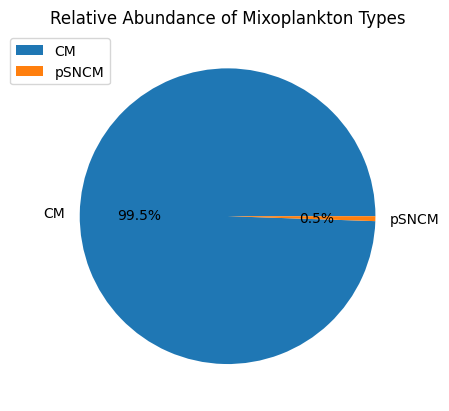

In [16]:
# Plot Data
plt.title("Relative Abundance of Mixoplankton Types")
plt.pie(counts['Percentages'], labels=counts['MFT'], autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(.2, 1))
plt.show()

## 3. For just the dinoflagellates, what fraction are phyto vs mixo vs heterotrophs?  
### All of the dinoflagellates that are in the genus Protoperidinium are strict heterotrophs. They only use phagocytosis for nutrition and are not capable of photosynthesis. They get counted in these kinds of monitoring programs just because the person doing the counting sees them but they are not phytoplankton at all.

In [18]:
# Clean Data
lis = classified.all_classified
lis = lis.loc[lis['Phylum'] == 'Dinoflagellate']
lis.loc[lis['Genus']=='Protoperidinium', 'Status'] = 'Heterotroph'
lis = lis.replace('No', 'Phototroph')
lis = lis.replace('Yes', 'Mixotroph')
counts = percentages(lis, 'Status')
counts

/var/folders/8f/krhzcyxd6c995sh8b6qrxymh0000gn/T/ipykernel_64872/419569337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lis.loc[lis['Genus']=='Protoperidinium', 'Status'] = 'Heterotroph'


,Status,Totals,Percentages
0,Heterotroph,38060.0,0.539861
1,Mixotroph,2666008.0,37.815917
2,Phototroph,4345894.66,61.644222


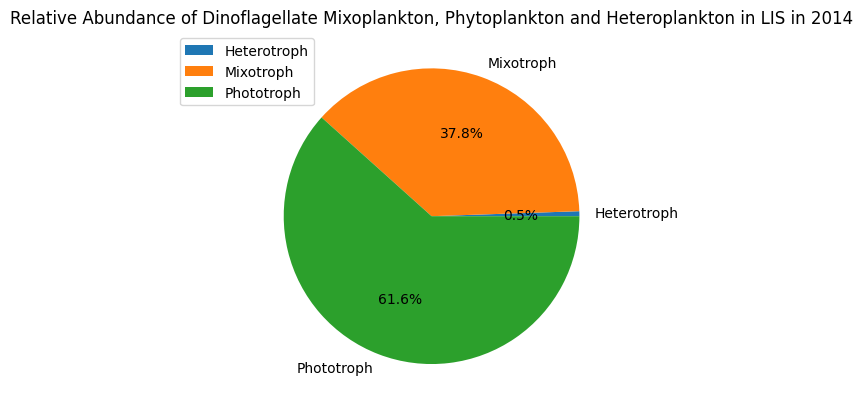

In [19]:
# Plot Data
plt.title("Relative Abundance of Dinoflagellate Mixoplankton, Phytoplankton and Heteroplankton in LIS in 2014")
plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(.2, 1))
plt.show()

## 4. What fraction of mixoplankton are nano size and micro size?

In [20]:
# Clean data
lis = classified.mixoplankton
counts = percentages(lis, 'size class')
counts

,size class,Totals,Percentages
2,micro,124476.0,0.412681
3,nano,2889717.0,9.580403


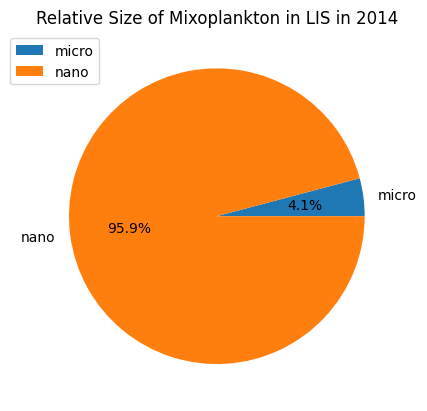

In [21]:
# Plot Data
plt.title("Relative Size of Mixoplankton in LIS in 2014")
plt.pie(counts['Percentages'], labels=counts['size class'], autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(.2, 1))
plt.show()

## 5. What proportion of the mixoplankton are dinoflagellates?

In [22]:
lis = classified.mixoplankton
counts = percentages(lis, 'Phylum')
counts

,Phylum,Totals,Percentages
0,Dinoflagellate,2666008.0,8.838731
1,Haptophyte,307089.0,1.018105
2,Ochrophyte (diatoms excluded),27136849.714,89.967967
3,Raphidophyte,52844.0,0.175196


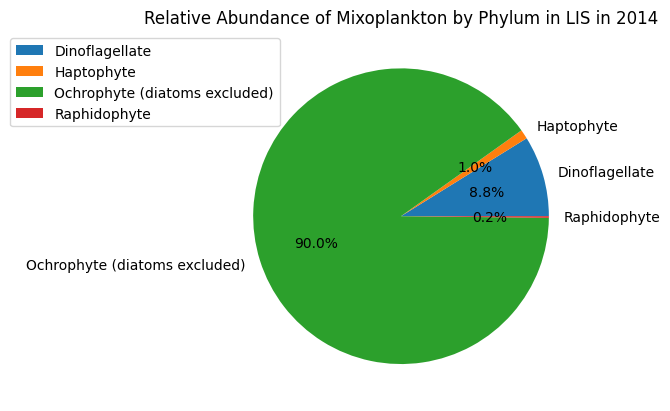

In [23]:
# Plot Data
plt.title("Relative Abundance of Mixoplankton by Phylum in LIS in 2014")
plt.pie(counts['Percentages'], labels=counts['Phylum'], autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(.19, 1))
plt.show()